In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

In [2]:
# path = '2019-11-22_19-07-57_その1.txt'
path = '2019-11-22_19-15-11_その2.txt'

In [3]:
columns = ["nSeq", "I1", "I2", "O1", "O2", "A1", "A2", "A3", "A4", "A5", "A6"]
sampling_rate = 1000

df = None
reader = pd.read_csv(path, sep='\t', header=None, names=columns, index_col=False, chunksize=600*sampling_rate)
for r in reader:
    if df is None:
        #  頭から3行目は要らない
        df = r.drop([i for i in range(3)])
    else:
        df = df.append(r, ignore_index=True)
        
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(485250, 11)


/Users/kessapassa/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,nSeq,I1,I2,O1,O2,A1,A2,A3,A4,A5,A6
0,0,0.0,0.0,0.0,0.0,510.0,497.0,102.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,509.0,499.0,102.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,509.0,499.0,102.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,506.0,500.0,102.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,505.0,501.0,102.0,0.0,0.0,0.0


In [4]:
target='A2'
df_target = df[target][10500:15500]
# df_target = df[target][450000:460000]

In [5]:
total_time = (df.shape[0] / sampling_rate)
df['seconds'] = df.index/sampling_rate
(df.shape[0] / sampling_rate) / 60

8.0875

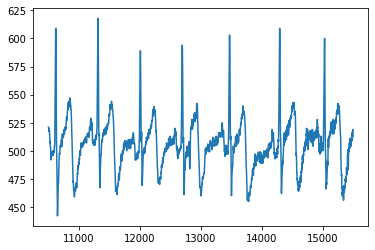

In [6]:
plt.plot(df_target)

# SGD分析

In [7]:
SGD = SGDRegressor(max_iter=500)
X = df_target.values.reshape(-1, 1)
Y = np.arange(df_target.shape[0]).reshape(-1, 1)
SGD.fit(X, Y)

/Users/kessapassa/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=500,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [8]:
SGD.intercept_

array([-3.34716857e+10])

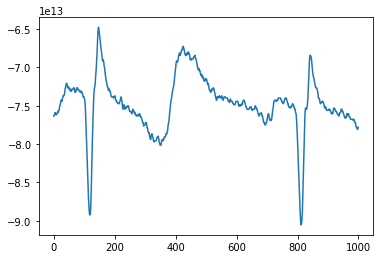

In [9]:
df = pd.read_csv('2019-11-22_19-15-11_その2.txt', sep='\t', skiprows=3, header=None, names=columns, index_col=False)
X = df[target][10500:11500].values.reshape(-1, 1)

# plt.figure(figsize=(100, 10), dpi=100)
plt.plot(SGD.predict(X))

# k近傍法による異常部位検知
https://blog.brains-tech.co.jp/entry/2017/10/17/170140

In [10]:
from sklearn.neighbors import NearestNeighbors

def embed(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) 
        emb = np.append( emb, tmp, axis=0)
    return emb

In [19]:
data = df['A2'].copy()
data = data[50000:]

split_range = 2000

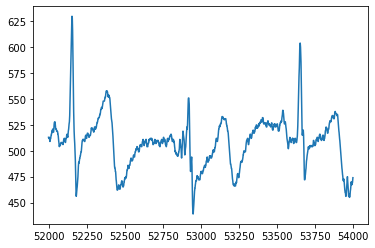

In [20]:
plt.plot(data[split_range:split_range*2])

In [44]:
def k_neiborhood(width=100, nk=1):
    train_data = data[:split_range].values
    test_data = data[split_range:split_range*2].values

    train = embed(train_data, width)
    test = embed(test_data, width)

    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]

    # 距離をmax1にするデータ整形
    mx = np.max(d)
    d = d / mx

    # プロット
    test_for_plot = data[split_range:split_range*2].values
    fig = plt.figure(figsize=(30, 10), dpi=50)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    d = d.reshape(d.shape[1], d.shape[0])
    for d_i in range(d.shape[0]):
        ax1.plot(d[d_i])
#         ax1.set_ylabel('distance', d_i)
        # ax1.set_ylim(0, 1.2)
    
    p2, = ax2.plot(test_for_plot, '-g')
    ax2.set_ylabel('original')
    # ax2.set_ylim(0, 12.0)
    plt.title("Nearest Neighbors")
#     ax1.legend([p1, p2], ["distance", "original"])
    # plt.savefig('./results/knn.png')
    plt.show()

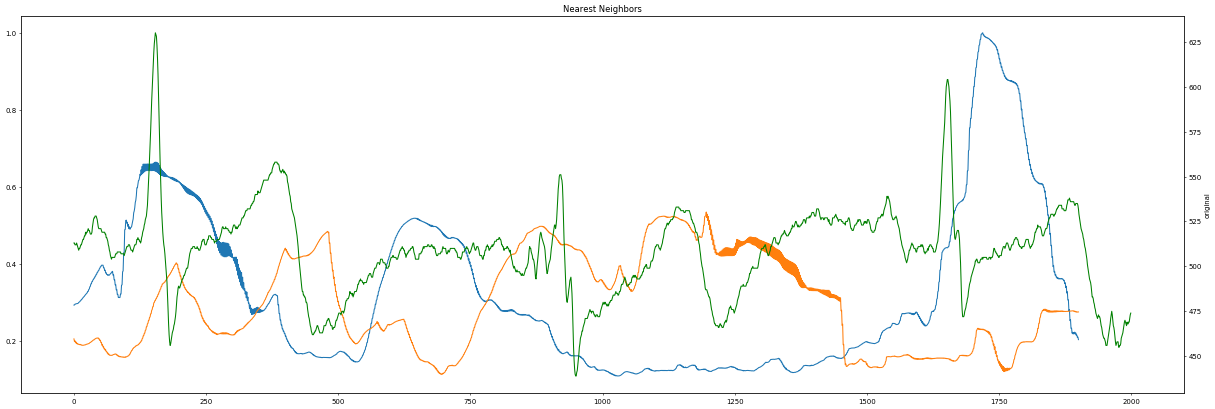

In [46]:
k_neiborhood(nk=2)

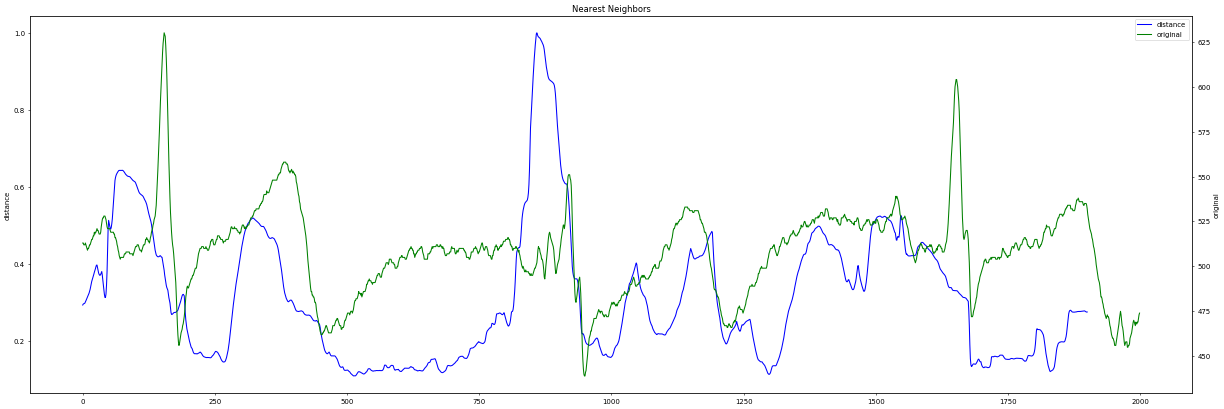

In [47]:
train_data = data[:split_range].values
test_data = data[split_range:split_range*2].values

width = 100
nk = 1

train = embed(train_data, width)
test = embed(test_data, width)

neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train)
d = neigh.kneighbors(test)[0]

# 距離をmax1にするデータ整形
mx = np.max(d)
d = d / mx

# プロット
test_for_plot = data[split_range:split_range*2].values
fig = plt.figure(figsize=(30, 10), dpi=50)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

p1, = ax1.plot(d, '-b')
ax1.set_ylabel('distance')
# ax1.set_ylim(0, 1.2)
p2, = ax2.plot(test_for_plot, '-g')
ax2.set_ylabel('original')
# ax2.set_ylim(0, 12.0)
plt.title("Nearest Neighbors")
ax1.legend([p1, p2], ["distance", "original"])
# plt.savefig('./results/knn.png')
plt.show()

# 特異スペクトル変換法による変化点検知

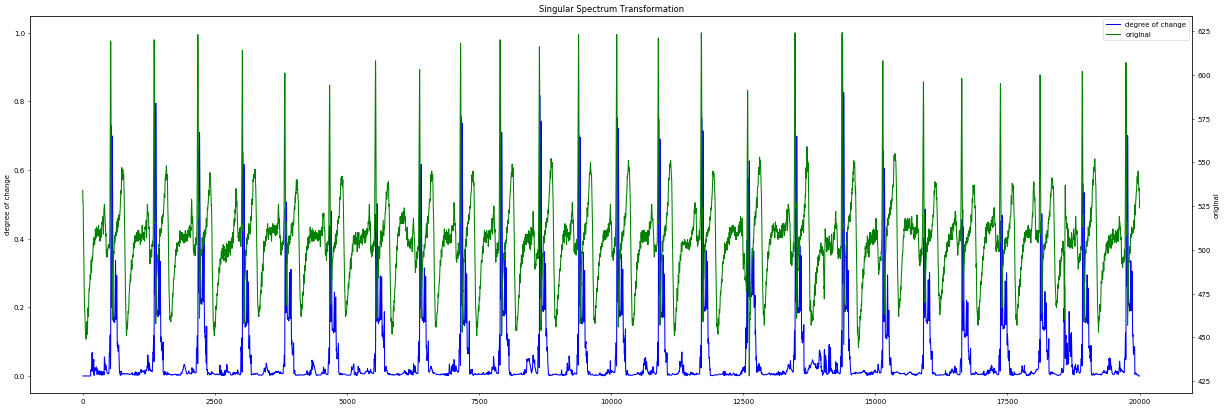

In [14]:
w = 100 # width
m = 2
k = w//2
L = k//2 # lag
Tt = test_data.size
score = np.zeros(Tt)

for t in range(w+k, Tt-L+1+1):
    tstart = t-w-k+1
    tend = t-1
    X1 = embed(test_data[tstart:tend], w).T[::-1, :] # trajectory matrix
    X2 = embed(test_data[(tstart+L):(tend+L)], w).T[::-1, :] # test matrix

    U1, s1, V1 = np.linalg.svd(X1, full_matrices=True)
    U1 = U1[:,0:m]
    U2, s2, V2 = np.linalg.svd(X2, full_matrices=True)
    U2 = U2[:,0:m]

    U, s, V = np.linalg.svd(U1.T.dot(U2), full_matrices=True)
    sig1 = s[0]
    score[t] = 1 - np.square(sig1)

# 変化度をmax1にするデータ整形
mx = np.max(score)
score = score / mx

# プロット
test_for_plot = data[split_range:split_range*2].values
fig = plt.figure(figsize=(30, 10), dpi=50)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

p1, = ax1.plot(score, '-b')
ax1.set_ylabel('degree of change')
# ax1.set_ylim(0, 1.2)
p2, = ax2.plot(test_for_plot, '-g')
ax2.set_ylabel('original')
# ax2.set_ylim(0, 12.0)
plt.title("Singular Spectrum Transformation")
ax1.legend([p1, p2], ["degree of change", "original"])
# plt.savefig('./results/sst.png')
plt.show()

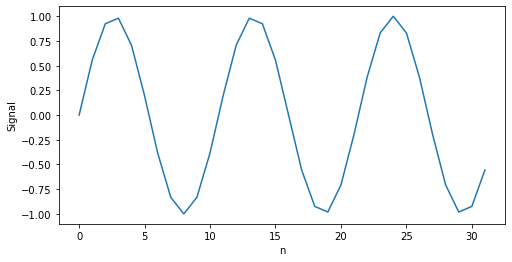

In [15]:
N = 32 # データ数
n = np.arange(N)
freq = 3 # 周期
f = np.sin(freq * 2 * np.pi * (n/N)) # freq=3周期分

# グラフ表示
plt.figure(figsize=(8, 4))
plt.xlabel('n')
plt.ylabel('Signal')
plt.plot(f)

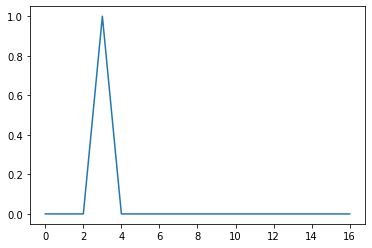

In [16]:
F = np.fft.fft(f)
F_abs = np.abs(F)
F_abs_amp = F_abs / N * 2 # 交流成分はデータ数で割って2倍する
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要
plt.plot(F_abs_amp[:int(N/2)+1])

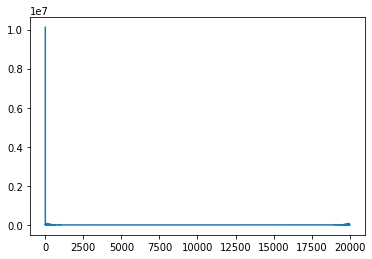

In [17]:
F = np.fft.fft(train_data)
F_abs = np.abs(F)
plt.plot(F_abs)